In [1]:
import os, sys
from PIL import Image

import rasterio
import pandas as pd
import matplotlib.pyplot as plt

from rasterio.warp import reproject, Resampling, calculate_default_transform
import numpy as np
from rasterio.enums import Resampling
from skimage.morphology import erosion, dilation, diamond, square, opening, disk
from scipy import ndimage
from datetime import datetime
from skimage.filters import threshold_local

import skimage
from skimage.segmentation import clear_border,watershed
from skimage.feature import peak_local_max
import cv2


In [6]:

## i dont think I use either of these functions...

def peakdet(v, delta, x = None):
    
    maxtab = []
    mintab = []
       
    if x is None:
        x = np.arange(len(v))
    
    v = np.asarray(v)
    
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    
    if not np.isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    
    mn, mx = np.Inf, -np.Inf
    mnpos, mxpos = np.NaN, np.NaN
    
    lookformax = True
   # mintab.append((0, 0.))
    
    for i in np.arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True
    return np.array(maxtab), np.array(mintab)

# def reproj_match(infile, match, outfile):
#     """Reproject a file to match the shape and projection of existing raster. 
    
#     Parameters
#     ----------
#     infile : (string) path to input file to reproject
#     match : (string) path to raster with desired shape and projection 
#     outfile : (string) path to output file tif
#     """
#     # open input
#     with rasterio.open(infile) as src:
#         src_transform = src.transform
        
#         # open input to match
#         with rasterio.open(match) as match:
#             dst_crs = match.crs
            
#             # calculate the output transform matrix
#             dst_transform, dst_width, dst_height = calculate_default_transform(
#                 src.crs,     # input CRS
#                 dst_crs,     # output CRS
#                 match.width,   # input width
#                 match.height,  # input height 
#                 *match.bounds)  # unpacks input outer boundaries (left, bottom, right, top))

#         # set properties for output
#         dst_kwargs = src.meta.copy()
#         dst_kwargs.update({"crs": dst_crs,
#                            "transform": dst_transform,
#                            "width": dst_width,
#                            "height": dst_height,
#                            "nodata": 0})
#         print("Coregistered to shape:", dst_height,dst_width,'\n Affine',dst_transform)
#         # open output
#         with rasterio.open(outfile, "w", **dst_kwargs) as dst:
#             # iterate through bands and write using reproject function
#             for i in range(1, src.count + 1):
#                 reproject(
#                     source=rasterio.band(src, i),
#                     destination=rasterio.band(dst, i),
#                     src_transform=src.transform,
#                     src_crs=src.crs,
#                     dst_transform=dst_transform,
#                     dst_crs=dst_crs,
#                     resampling=Resampling.nearest)



/var/folders/d9/yt5cny_52dg1hlsrpkcxnydr0000gp/T/ipykernel_42966/2339596862.py:128: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax=plt.subplots(1,1,figsize=(6,2))


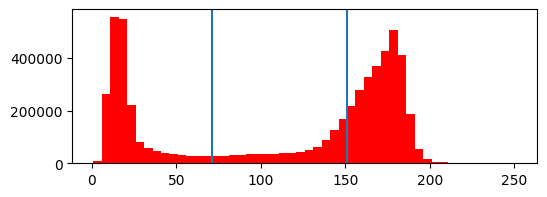

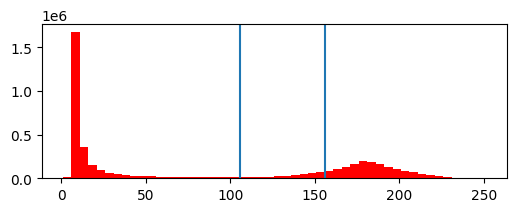

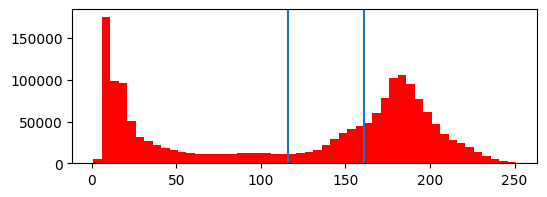

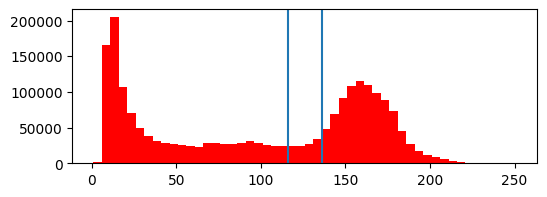

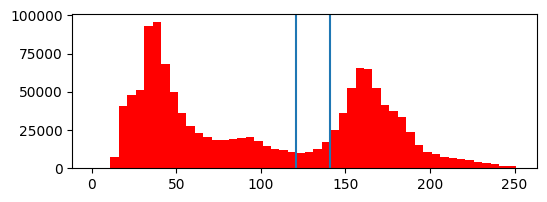

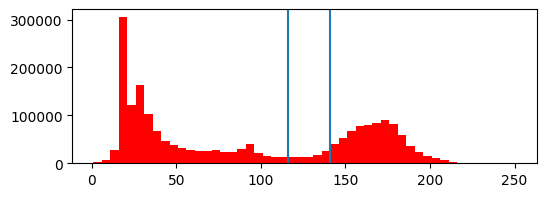

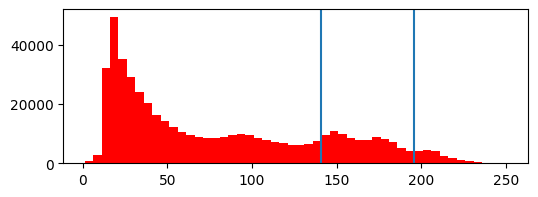

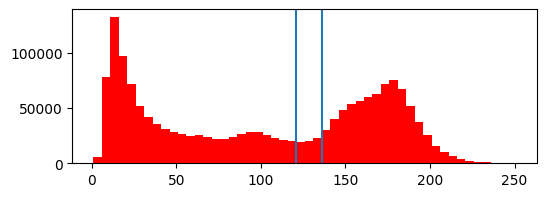

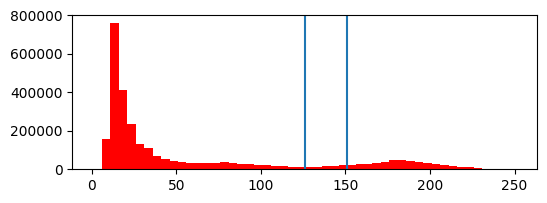

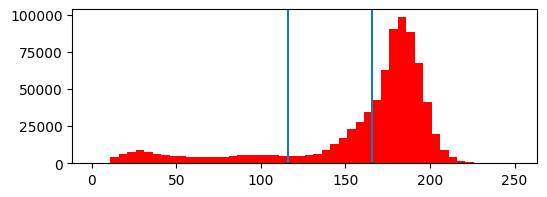

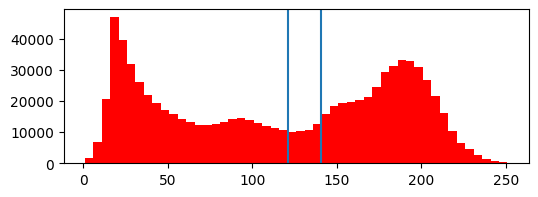

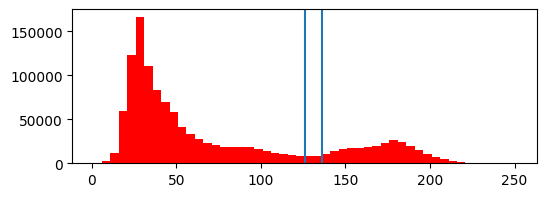

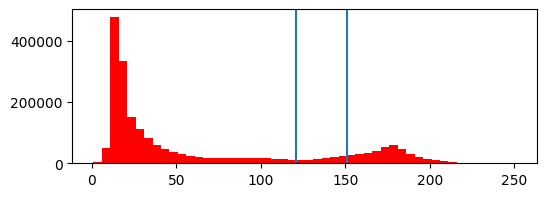

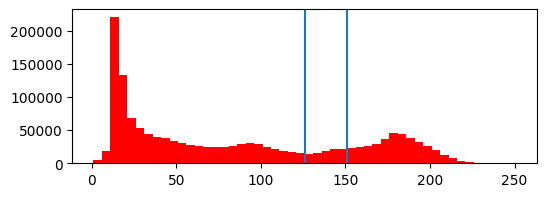

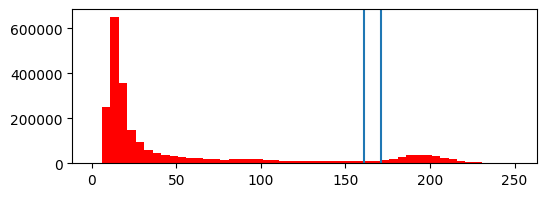

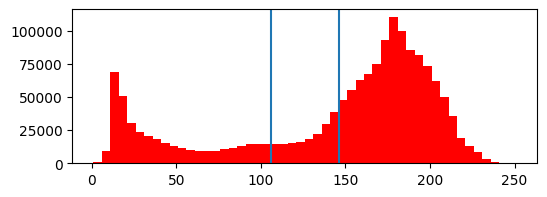

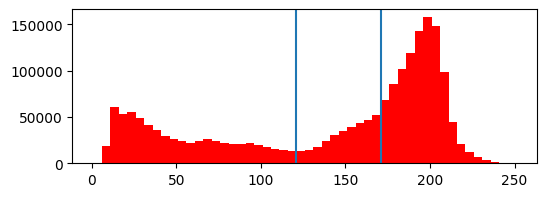

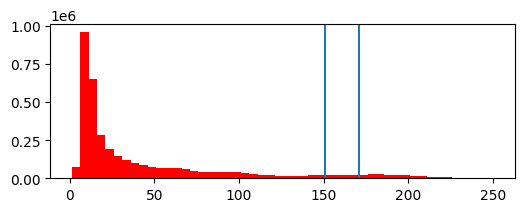

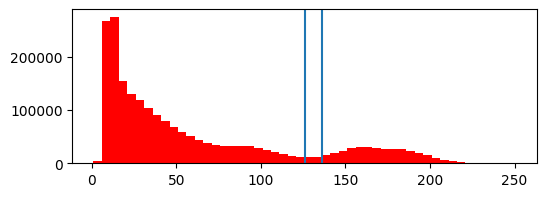

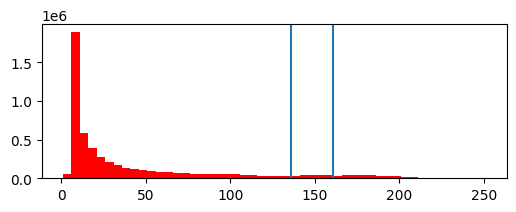

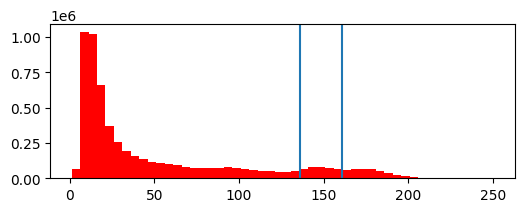

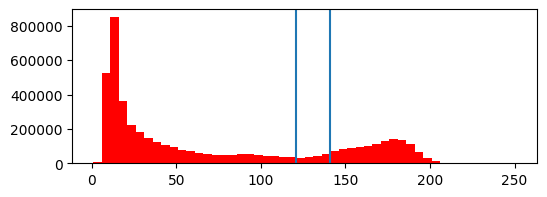

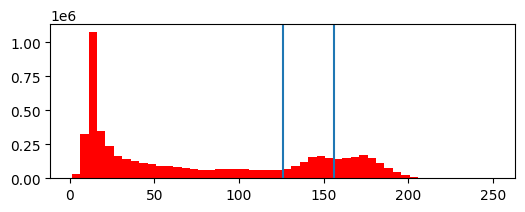

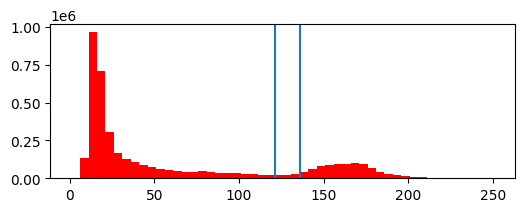

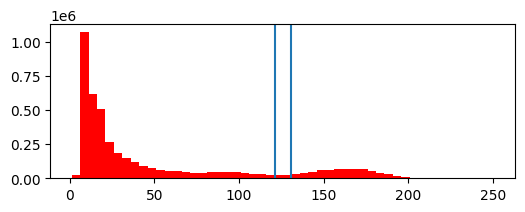

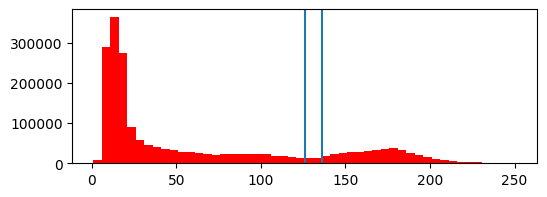

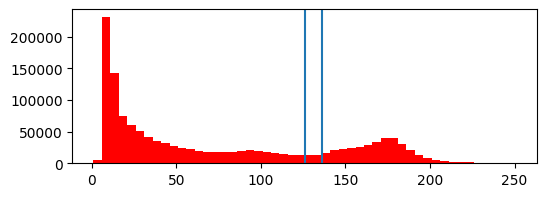

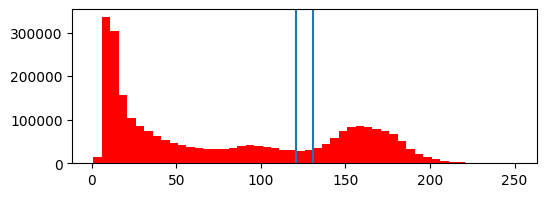

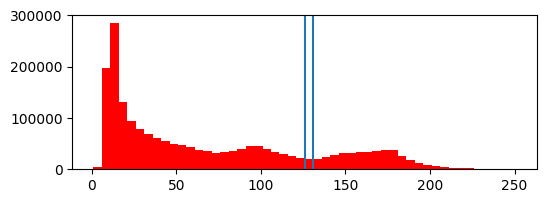

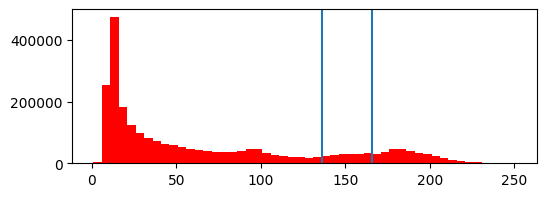

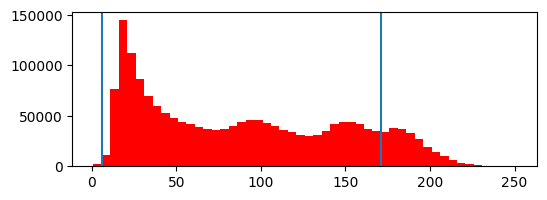

In [7]:


# ## land mask
# this is the same landmask as the original IFT- can be downloaded w SOIT
outfile='/Users/ellenbuckley/Documents/Analysis/FSD/for_ccv/reproj_land.tiff'
s=rasterio.open(outfile)
land_mask=(s.read()[0])==75


# ## load files


data_direc='/Users/ellenbuckley/Documents/Analysis/FSD/for_ccv/input/'
save_direc='/Users/ellenbuckley/Documents/Analysis/FSD/for_ccv/output/'
ftci_direc=data_direc+'tci/'
#ffci_direc=data_direc+'fci/'
fcloud_direc=data_direc+'cloud/'

#option to save figs after each step
save_figs=True

#year=2006
for y in [2012]:# in np.arange(2012,2016,1):
    year=y
    for i in np.arange(214,245,1):# 94,274range of julian days where there is light in the Beaufort Sea

        doy=i
        aq=False # aqua or terra

        doy_str = str(doy)
        year_str = str(year)

        # adjusting day num
        doy_str.rjust(3 + len(doy_str), '0')
        
        # converting to date
        res = datetime.strptime(year_str + "-" + doy_str, "%Y-%j").strftime("%Y-%m-%d")

        if aq:
            sat='aqua'
        else:
            sat='terra'

        fcloud=fcloud_direc+'cloud_'+res+'_'+str(doy)+'_'+sat+'.tiff'
        ftci=ftci_direc+'tci_'+res+'_'+str(doy)+'_'+sat+'.tiff'
        
        
        #open all files
        cloud=rasterio.open(fcloud)
        tci=rasterio.open(ftci)

        # this pulls in the cloud mask file where red indicates >95% cloud cover
        # so that is what I am masking out here
        # but I think could just change to reading in false color and doing a...
        # simple cloud mask from the first (NIR) channel as in original IFT
        
        cloud_mask=(cloud.read()[0])==255

        red_c=np.copy(tci.read()[0])
        green_c=np.copy(tci.read()[1])
        blue_c=np.copy(tci.read()[2])
        rgb=np.dstack([red_c,green_c,blue_c])

        
        if save_figs==True:
            
            # save cloud mask on RGB
            red_cmasked=np.copy(tci.read()[0])
            green_cmasked=np.copy(tci.read()[1])
            blue_cmasked=np.copy(tci.read()[2])

            red_cmasked[cloud_mask]=0
            green_cmasked[cloud_mask]=0
            blue_cmasked[cloud_mask]=0
            rgb=np.dstack([red_cmasked,green_cmasked,blue_cmasked])
            with rasterio.Env():
                profile = tci.profile
                profile.update(
                    dtype=rasterio.uint8,
                    count=3,
                    compress='lzw')

                with rasterio.open(save_direc+str(doy)+'cloud_mask_on_rgb.tif', 'w', **profile) as dst:
                    dst.write(np.rollaxis(rgb, axis=2))
            
            
            # save land AND cloud mask on RGB
            red_cmasked[land_mask]=0
            green_cmasked[land_mask]=0
            blue_cmasked[land_mask]=0
            rgb=np.dstack([red_cmasked,green_cmasked,blue_cmasked])
            with rasterio.Env():
                profile = tci.profile
                profile.update(
                    dtype=rasterio.uint8,
                    count=3,
                    compress='lzw')

                with rasterio.open(save_direc+str(doy)+'land_cloud_mask_on_rgb.tif', 'w', **profile) as dst:
                    dst.write(np.rollaxis(rgb, axis=2))

                    
        ## adaptive threshold for ice mask
        red_masked=red_c=np.copy(tci.read()[0])
        image = red_masked
        thresh_adaptive = threshold_local(image, block_size=399)
        
        # make sure land and cloud are already masked out
        red_masked[(land_mask|cloud_mask)]=0
    
        # here just determining the min and max values for the adaptive threshold
        binz=np.arange(1,256,5)
        rn,rbins=np.histogram(red_masked.flatten(),bins=binz)
        dx=.01*np.mean(rn)
        rmaxtab,rmintab=peakdet(rn,dx,x=None)
        rmax_n=rbins[rmaxtab[-1,0]]
        rm1_n=rbins[rmaxtab[0,0]]
        rhm_high=rmaxtab[-1,1]/2
        rhm_low=rmaxtab[0,1]/4
        
        if ~np.any(rmintab):
            ow_cut_min=100
        else:
            ow_cut_min=rbins[rmintab[-1,0]]
        if np.any(np.where((rbins[:-1]<rmax_n)&(rn<=rhm_high))):     
            ow_cut_max=rbins[np.where((rbins[:-1]<rmax_n)&(rn<=rhm_high))[0][-1]]#fwhm to left of ice max
        else:
            ow_cut_max=rmax_n-10
        if save_figs==True:
            fig,ax=plt.subplots(1,1,figsize=(6,2))
            plt.hist(red_masked.flatten(),bins=binz,color='r')
            plt.axvline(ow_cut_max)
            plt.axvline(ow_cut_min)
            plt.savefig(save_direc+'ice_mask_hist.png')

        thresh_adaptive[thresh_adaptive<ow_cut_min]=ow_cut_min
        thresh_adaptive[thresh_adaptive>ow_cut_max]=ow_cut_max
        ice_mask=image> thresh_adaptive
        
        
        # a simple text file with columns: 'doy','ice_area','unmasked','sic'
        with open(save_direc+str(doy)+'mask_values_'+str(year)+'.txt', 'a') as f:
            f.write(str(doy)+ '\t' +str(sum(sum(ice_mask)))+ '\t'+str(sum(sum(~(land_mask+cloud_mask))))+ '\t'+str(sum(sum(ice_mask))/sum(sum(~(land_mask+cloud_mask))))+'\n')

        # saving ice mask
        if save_figs==True:
            with rasterio.Env():
                profile = tci.profile
                profile.update(
                    dtype=rasterio.uint8,
                    count=1,
                    compress='lzw')

                with rasterio.open(save_direc+str(doy)+'ice_mask_bw.tif', 'w', **profile) as dst:
                    dst.write(ice_mask.astype(rasterio.uint8), 1)
        
        
        # here dialating the land and cloud mask so any floes that are adjacent to the mask can be removed later
        lmd=land_mask+cloud_mask
        kernel = diamond(10)#np.ones((3,3), np.uint8)
        lmd= skimage.morphology.binary_dilation((land_mask+cloud_mask).astype(int), kernel)
        
        # setting up different kernel for erosion-expansion algo
        kernel_er1=diamond(1)
        kernel_er2=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))

        inp=ice_mask
        input_no= ice_mask
        r=0
        output=np.zeros((np.shape(ice_mask)))
        
        
        for n in np.arange(8,2,-1):
            it=n
            # erode a lot at first, decrease number of iterations each time
            im3=cv2.erode(inp.astype(np.uint8),kernel_er1,iterations=it)
            im3= ndimage.binary_fill_holes(im3.astype(np.uint8))
           
            im2=cv2.dilate(inp.astype(np.uint8),kernel_er1,iterations=it)
            
            # label floes remaining after erosion
            ret, markers = cv2.connectedComponents(im3.astype(np.uint8))

            # Add one to all labels so that sure background is not 0, but 1
            markers = markers+1


            unknown = cv2.subtract(im2.astype(np.uint8),im3.astype(np.uint8))
            
            # Now, mark the region of unknown with zero
            markers[unknown==255] = 0

            #dilate each marker
            for a in np.arange(0,it+1,1):
                markers=skimage.morphology.dilation(markers,kernel_er1)


            #rewatershed
            im4 = cv2.watershed(rgb,markers)

            # get rid of floes that intersect the dilated land mask
            im4[np.isin(im4,np.unique(im4[(lmd==True)&(im4>1)]))]=1
            
            # set the open water and already identified floes to no
            im4[input_no==False]=1


           # get rid of ones that are too small
            area_lim=(it)**4
            props = skimage.measure.regionprops_table(im4,properties=['label', 'area'])
            df=pd.DataFrame.from_dict(props)
            im4[np.isin(im4,df[df.area<area_lim].label.values)]=1
            
            if save_figs==True:
                with rasterio.Env():

                    # Write an array as a raster band to a new 8-bit file. For
                    # the new file's profile, we start with the profile of the source
                    profile = tci.profile

                    # And then change the band count to 1, set the
                    # dtype to uint8, and specify LZW compression.
                    profile.update(
                        dtype=rasterio.uint8,
                        count=1,
                        compress='lzw')

                    with rasterio.open(save_direc+str(doy)+'identification_round_'+str(r)+'_not_sharp8_m1_nows.tif', 'w', **profile) as dst:
                        dst.write(im4.astype(rasterio.uint8), 1)
            
           
            r+=1  # r is just for tracking the iteration round for naming figures
            
            input_no=ice_mask+inp
            inp=((im4==1)&(inp==1)&ice_mask)
            im4[im4<2]=0
            output=im4+output
        
        
        # saving the props table
        output=opening(output)
        props = skimage.measure.regionprops_table(output.astype(int),red_c,properties=['label', 'area','centroid',
                                                                                  'axis_major_length','axis_minor_length',
                                                                                'orientation','perimeter','intensity_mean'])
        df=pd.DataFrame.from_dict(props)
        df.to_csv(save_direc+res+'_'+str(doy)+'_'+sat+'.csv')

        
        # saving the label floes tif
        with rasterio.Env():
                profile = tci.profile
                profile.update(
                    dtype=rasterio.uint8,
                    count=1,
                    compress='lzw')
                with rasterio.open(save_direc+res+'_'+str(doy)+'_'+sat+'_final.tif', 'w', **profile) as dst:
                    dst.write(output.astype(rasterio.uint8), 1)


